In [3]:
import sys
sys.path.insert(0,'/home/jovyan/work/src/')
from sqlalchemy import create_engine, MetaData, select, func
from sqlalchemy.orm import sessionmaker
from arise.barcode.metadata.orm.barcode import Barcode
from arise.barcode.metadata.orm.marker import Marker
from arise.barcode.metadata.orm.nsr_species import NsrSpecies
from arise.barcode.metadata.orm.nsr_synonym import NsrSynonym
from arise.barcode.metadata.orm.nsr_node import NsrNode
from arise.barcode.metadata.orm.specimen import Specimen
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from ete3 import Tree, TreeStyle
import os
from ipywidgets import IntProgress
from IPython.display import display

os.environ['QT_QPA_PLATFORM']='offscreen'  # to avoid to kill the kernel using ete render
os.environ['XDG_RUNTIME_DIR']='/tmp/runtime-jovyan'

In [4]:
engine = create_engine('sqlite:////home/jovyan/work/data/sqlite/arise-barcode-metadata_old.db', echo=False)

# make session
Session = sessionmaker(engine)
session = Session()

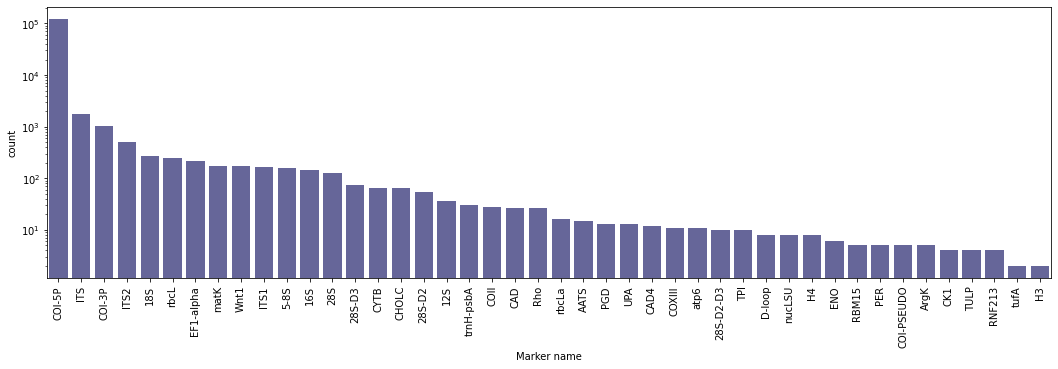

In [5]:
nsr_barcodes = session.query(Barcode).all()
data = [el.marker.marker_name for el in nsr_barcodes]
df = pd.DataFrame(data, columns=['Marker name'])
fig, ax = plt.subplots(figsize=(18,5))
sb.countplot(data=df, x='Marker name', ax=ax, color='b', saturation=0.2, order = df['Marker name'].value_counts().index)
ax.set_yscale('log')
ax.tick_params(axis="x", rotation=90)

<AxesSubplot:xlabel='count', ylabel='Institution'>

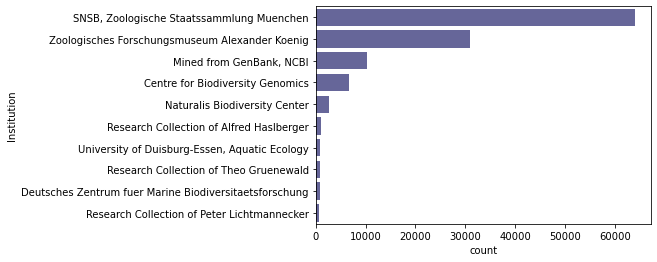

In [6]:
institutions = session.query(Specimen.institution_storing).all()
institutions = [e[0] for e in institutions if e[0]]
df = pd.DataFrame(institutions, columns=['Institution'])
indices = df['Institution'].value_counts().index
sb.countplot(data=df, y='Institution', color='b', saturation=0.2, order = indices[0:10])

In [7]:
# util fonctions

# walks across the tree, stores number of tips and barcodes as total_sp and total_bc
# populates an ete3 tree up to max_rank level, e.g. families as tips
# tags the nodes with their taxonomic rank
def recurse(nsr_node, ete_node, max_rank, session, f):
    
    # at this level we don't recurse further
    # instead we collect the tips and count their barcodes
    if nsr_node.rank == max_rank:
        tips = nsr_node.get_leaves(session).all()
        total_bc = 0
        for tip in tips:
            
            # this should be done using a relationship instead
            specimens = session.query(Specimen).filter(Specimen.species_id == tip.species_id)
            for spec in specimens:
                barcodes = spec.barcodes
                total_bc += len(barcodes)
                
        # total_sp = total species tips below current node
        # total_bc = total barcodes below current node
        ete_node.add_feature('total_sp', len(tips))
        ete_node.add_feature('total_bc', total_bc)        
        f.value += len(tips) # progress bar
    else:
        
        # we only reach this block in cases when we are
        # at a higher taxon level than max_rank, i.e.
        # if max_rank = 'family', then this is order, class, etc.
        total_bc = 0
        total_sp = 0
        
        # iterate over direct children in database
        for child in nsr_node.get_children(session):
            
            # instantiate an ETE mirror of the child, with rank and name
            ete_child = ete_node.add_child(name = child.name)
            ete_child.add_feature('rank', child.rank)
            
            # traverse deeper
            recurse(child, ete_child, max_rank, session, f)
            
            # we only reach here in the post-order, i.e. after all
            # children have been treated, so we can accumulate their
            # tip and barcode counts to carry over toward the root
            total_bc += ete_child.total_bc
            total_sp += ete_child.total_sp
        
        # store current subtotals
        ete_node.add_feature('total_sp', total_sp)
        ete_node.add_feature('total_bc', total_bc)          
        

def get_species_barcode_count():
    # prefetch number of barcodes per species_id
    query = session.query(Specimen.species_id, func.count()).join(Barcode).group_by(Specimen.species_id)
    return { e:c for e, c in query.all() }


def add_count_features(tree, max_rank, species_bc_dict):
    for node in tree.iter_descendants(strategy='postorder'):
        if node.rank == max_rank:
            tips = session.query(NsrNode).filter(NsrNode.id == node.id).first().get_leaves(session).all()
            total_bc = 0
            for tip in tips:
                if tip.species_id and tip.species_id in species_bc_dict:
                    total_bc += species_bc_dict[tip.species_id]
            node.add_feature('total_sp', len(tips))
            node.add_feature('total_bc', total_bc)   
        else:
            total_sp = 0
            total_bc = 0
            for child in node.get_children():
                total_sp += child.total_sp
                total_bc += child.total_bc
            node.add_feature('total_sp', total_sp)
            node.add_feature('total_bc', total_bc)


In [8]:
# here we go and traverse the tree from the root
nsr_root = NsrNode.get_root(session)
print(nsr_root.name)

All of life


In [9]:
# instantiate tree
if False:
    tree = Tree()
    ete_root = tree.add_child(name = nsr_root.name)
    ete_root.add_feature('rank','life')

    # configure progress bar
    max_count = session.query(NsrSpecies.species_id).count()
    f = IntProgress(min=0, max=max_count)
    display(f)

    # start recursing. this will take a while!
    # recurse(nsr_root, ete_root, 'family', session, f)     
    f.value = max_count
    print("Done. Now that you sat through this, store the result in the next cell.")

In [10]:
# here we store the previously computed tree so we don't have to rerun the costly operation
%store tree

UsageError: Unknown variable 'tree'


In [ ]:
%store -r tree

In [17]:
# instantiate tree2
# tree = Tree()
# ete_root = tree.add_child(name = nsr_root.name)
# ete_root.add_feature('rank','life')
# nsr_root = session.query(NsrNode).filter(NsrNode.name == 'Insecta').first()

max_rank = 'family'
nsr_root = session.query(NsrNode).filter(NsrNode.name == 'All of life').first()
nsr_root.rank = 'life'
# nsr_root = session.query(NsrNode).filter(NsrNode.name == 'Insecta').first()
tree = nsr_root.to_ete(session, max_rank)

tree_root = tree.get_tree_root().get_children()[0]
if not tree_root.rank:
    tree_root.add_feature('rank', 'life')
d = get_species_barcode_count()
add_count_features(tree, max_rank, d)
print('total_sp', tree_root.total_sp)
print('total_bc', tree_root.total_bc)

total_sp 65293
total_bc 110114


In [2]:
# This is the part where we have to play with ETE's options to make this cool. Ideas:
# - It should be possible to render the tree only up to a specified level, e.g.
#   'phylum' or 'class'. There are several challenges: 1) we have a lot of 'incertae sedis'
#   that are grafted on anonymous parents, 2) the ETE API behaves inpredictably, I
#   try to prune children below a specified level but nothing seems to happen, 3)
#   there appear to be cycles in the data structure (and database), probably due to
#   faulty DarwinCore output.
# - It should also be possible to render from another node than the root. I think 
#   that might just be matter of finding the right node and rendering from there,
#   e.g. showing all the Molluscs or whatever.
# - Visualizing the features (n tips, n barcodes) is possible through the 'faces',
#   example is here: https://www.biostars.org/p/153788/
# Nice to have but not essential:
# - Color coding would be nice for the clades. A way to do that is use HSV instead
#   of RGB, divide 360 by number of children's descendants (at root), then subdivide 
#   the segments further as you approach the tips.
# - It would be nice if we can collapse unbranched internal nodes, for monotypic
#   higher taxa.


circular_style = TreeStyle()
circular_style.mode = "c" # draw tree in circular mode
circular_style.scale = 20
circular_style.show_leaf_name = False
circular_style.draw_guiding_lines = False
tree.render(file_name='%%inline', w=1200, tree_style=circular_style)

NameError: name 'TreeStyle' is not defined